In [1]:
################ Initialization

### Load libraries
library(sound)
library(RColorBrewer)
library(randomForest)
library(mgcv)
library(kernlab)
library(soundgen)

# Set working directory
setwd("C:\\LocalDocuments\\Projects\\PortlandDataScience")

randomForest 4.6-14
Type rfNews() to see new features/changes/bug fixes.
Loading required package: nlme
This is mgcv 1.8-28. For overview type 'help("mgcv-package")'.


In [2]:
################ Function definitions

# Read .wav files from a directory
readWaveFiles = function(dir='numbers\\numbers'){
  dr = getwd()
  setwd(dir)
  ff = list.files()
  nf = length(ff)
  wavs = list()

  for(i in 1:nf){
    wavs[[i]] = loadSample(ff[i])
  }
  names(wavs) = ff
  setwd(dr)

  wavs
}

# Create an object that clips .wav data and stores as time series
newTimeSeries = function(wv, transform=function(x)x, clip1=500, clip2=500){
  xx = as.vector(wv$sound)
  nx = length(xx)
  ix = (1:nx)[-c(1:clip1,nx-(1:clip2)+1)]
  list(`time`=ix-1, `data`=transform(xx[ix]))
}

# Plot raw time series data
plotRawWave = function(ts, transform=function(x)x, clip1=500, clip2=500,...){
  xx = ts$data
  tt = ts$time
  plot(tt, transform(xx), type='l', xlab='time', ylab='amplitude',...)
}


# Use generalized additive model (GAM) to calculate a smooth envelope
# Note:  the statistically proper approach would be to use a quasipoisson model
#   but due to computational costs of nonlinear models, the Gaussian model is
#   being used as a decent approximation.
getSmoothEnvelope = function(ts){
  y = ts$data
  x = ts$time
  gf = gam(y~s(x))
  predict(gf)
}

# Get peak stats from GAM-based envelope
getEnvelopePeakStats = function(ts, env, errorClip=5000){
  i0 = which.max(env) # Get index corresponding to maximum envelope

  # If maximum occurs at the beginning, clip some more from the beginning
  if(i0==1) {
     i0=which.max(env[-(1:errorClip)])+errorClip
     cat('\tclipped\n')
  }
  y0 = env[i0]
  d1 = diff(env)  # First difference
  d2 = diff(d1)  # Second difference
  a0 = d2[i0-1]
  
  # Half-width calculated as the difference between peak and x-intercepts
  # of the parabola implied by the 2nd difference and the peak height
  halfwidth = sqrt(-y0/a0) 

  out = c(`peakheight`=y0,`peak`=ts$time[i0],`curvature`=a0,`peakwidth`=halfwidth)
  names(out) = c('peakheight','peak','curvature','peakwidth')
  out
}

# Create a modified spectrogram based on centered and rescaled data
getCentralSpectrogram = function(ts, mu, sigma, scale, zvalue=3, rate=8000, main=''){
  xx = ts$data/scale
  nx = length(xx)
  flag = which(abs(ts$time-mu)/sigma<=zvalue)

  out = spectrogram(xx[flag], samplingRate=rate, output='processed')
  title(main=main)
  out
}

# Align spectrogram data to a uniform set of times and frequencies
alignSpectrum = function(S, freq=seq(0,4,0.1), time=seq(100,600,25)){
  mapF = approxfun(as.numeric(rownames(S)),1:nrow(S))
  mapT = approxfun(as.numeric(colnames(S)),1:ncol(S))
  fi = round(mapF(freq))
  ti = round(mapT(time))
  S[fi,ti]
}

# Create a randomly generated partion for K-fold cross-validation
randomlyPartition = function(i, folds=10){
  split(i, sample(1:folds, length(i), replace=TRUE))
}

# Plot a centered waveform with envelope, weight function, etc.
plotWeightedCenteredWaveForm = function(ts, env, errorClip=5000, legendpos='topright'){

   stat = getEnvelopePeakStats(ts, env, errorClip)

   xx = ts$data/stat["peakheight"]
   nx = length(xx)
   tt = ts$time-stat["peak"]

   sigma=stat["peakwidth"]
   sigma2=sigma*sigma

   wt = exp(-tt*tt/sigma2/2)

   plot(tt, ts$data, type='l', xlab='centered time', ylab='amplitude')
   wt = wt*(par()$usr[4]/max(wt))

   lines(tt, env, col='red', lwd=2)
   lines(tt, wt, col='royalblue', lty=2, lwd=2)
   lines(c(-1,1)*stat["peakwidth"], c(1,1)*par()$usr[3]/2, lwd=5, col='forestgreen')
   legend(legendpos, 
     c('abs val of waveform','GAM-based envelope', 'FFT weight', 'width parameter'), 
     lty=c(1,1,2,1), lwd=c(1,2,2,5), col=c('black','red','royalblue','forestgreen'), cex=0.8)
}

In [3]:
################ Read data (and other initialization)

# Palette for classes
PALETTE = c(brewer.pal(7,'Set1'), brewer.pal(6,'Set3'))

# Read in training data set #1
train1 = readWaveFiles()
yTrain1 = substring(names(train1),1,2)
ixTrain1 = split(1:length(yTrain1), yTrain1)

# Read in training data set #2
train2 = readWaveFiles('moreNumbers\\numbers')
yTrain2 = substring(names(train2),1,2)
ixTrain2 = split(1:length(yTrain2), yTrain2)

# Combine training sets
TRAINING.X = c(train1, train2)
TRAINING.Y = c(yTrain1, yTrain2)

# Create clipped time series objects
tsAll = lapply(TRAINING.X, newTimeSeries)
tsAbs = lapply(TRAINING.X, newTimeSeries, transform=abs)

In [4]:
if(!file.exists('gam-envelopes-190627.rds')) {
  # First time:  get smooth envelopes and save (due to length of time to process)
  rs.env = list()
  for(i in 1:length(tsAbs)){
    cat(i,'\n')
    rs.env[[i]] = getSmoothEnvelope(tsAbs[[i]])
    plotRawWave(tsAbs[[i]])
    lines(tsAbs[[i]]$time, rs.env[[i]], col='red')
  }

  saveRDS(rs.env, file='gam-envelopes-190627.rds')
}

if(file.exists('gam-envelopes-190627.rds')){
  # Later times (after smooth envelopes have been saved)
  rs.env = readRDS('gam-envelopes-190627.rds')
}

In [5]:
# Get the peak envelope stats for all files
rs.stat = t(mapply(getEnvelopePeakStats, ts=tsAbs, env=rs.env))

	clipped
	clipped
	clipped
	clipped
	clipped
	clipped
	clipped
	clipped


In [6]:
if(!file.exists('spectrograms-190702.rds')) {
  rs.spectroList = list()
  for(i in 1:length(tsAbs)){
     rs.spectro[[i]] = try(getCentralSpectrogram(tsAbs[[i]], 
        mu=rs.stat[i,"peak"], sigma=rs.stat[i,"peakwidth"], scale=rs.stat[i,"peakheight"], 
        rate=8000*rs.stat[i,"peakwidth"]/1000, main=as.character(i)))
  }
  saveRDS(rs.spectro, file='spectrograms-190702.rds')
}

if(file.exists('spectrograms-190702.rds')) {
  rs.spectro = readRDS('spectrograms-190702.rds')
}

# Find errors
flag = !sapply(rs.spectro, function(u)inherits(u,'try-error'))
sum(!flag)  # How many?


[1] 4

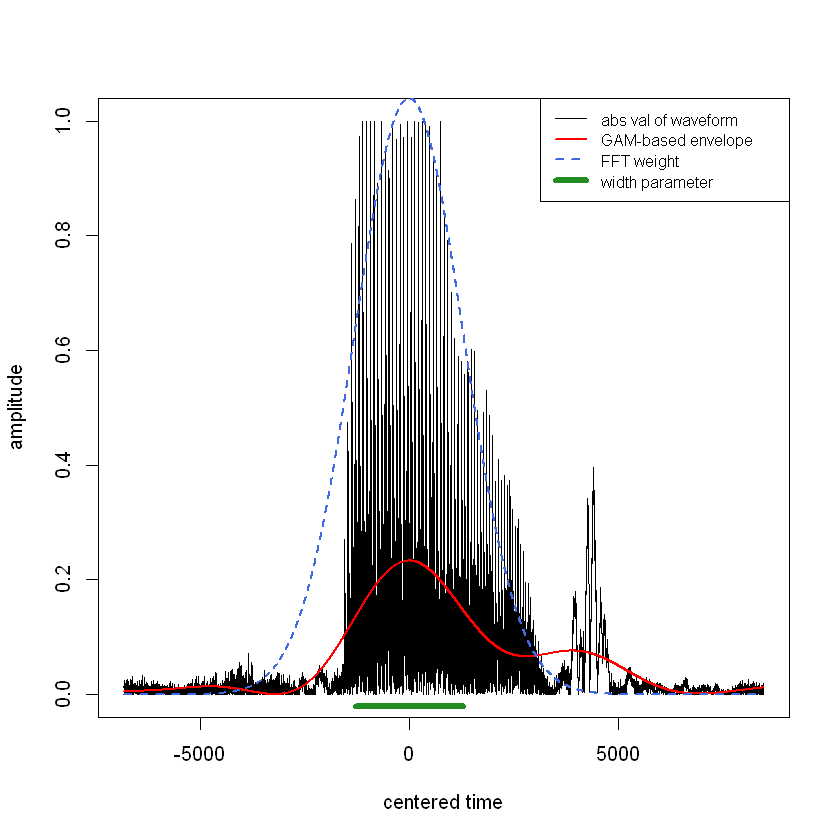

In [7]:
# Plot example of waveform envelope and statistics
plotWeightedCenteredWaveForm(tsAbs[[106]], rs.env[[106]])

In [8]:
# Get aligned spectrograms
rs.spectroAligned = sapply(rs.spectro[flag], 
  function(x) as.vector(alignSpectrum(x,freq=seq(0,4,0.025),time=seq(100,600,10))))

# Infill missing values
rs.spectroAligned[is.na(rs.spectroAligned)] = 0


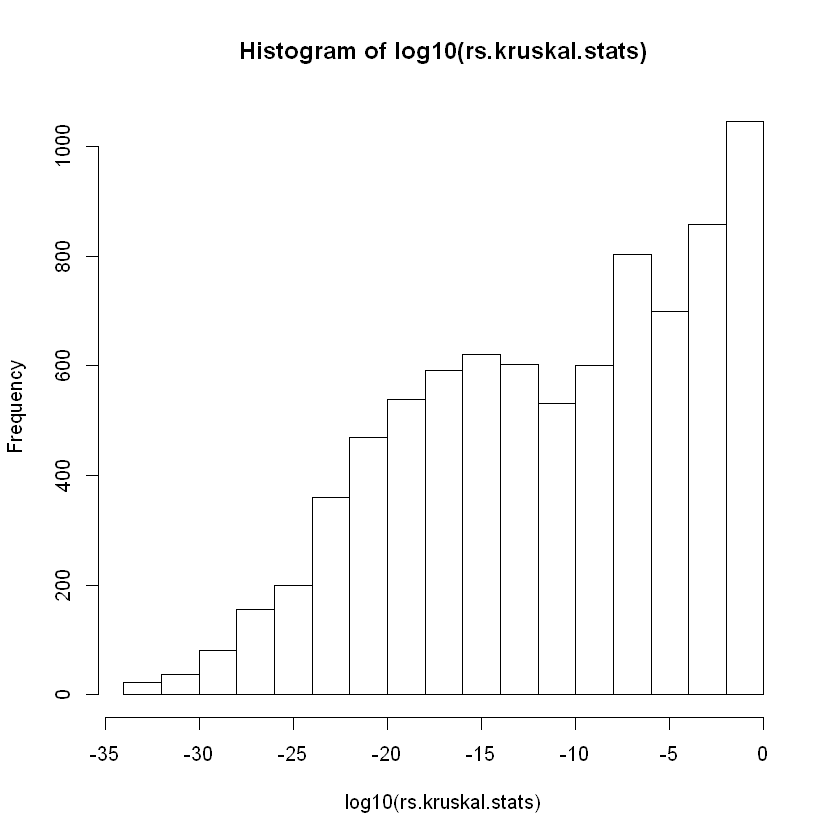

In [9]:
# Get Kruskal-Wallis p-values for association between classes and spectrogram data
rs.kruskal.stats = apply(rs.spectroAligned,1,
  function(u)kruskal.test(u~factor(TRAINING.Y[flag]))$p.value)

# View distribution of p-values
hist(log10(rs.kruskal.stats))

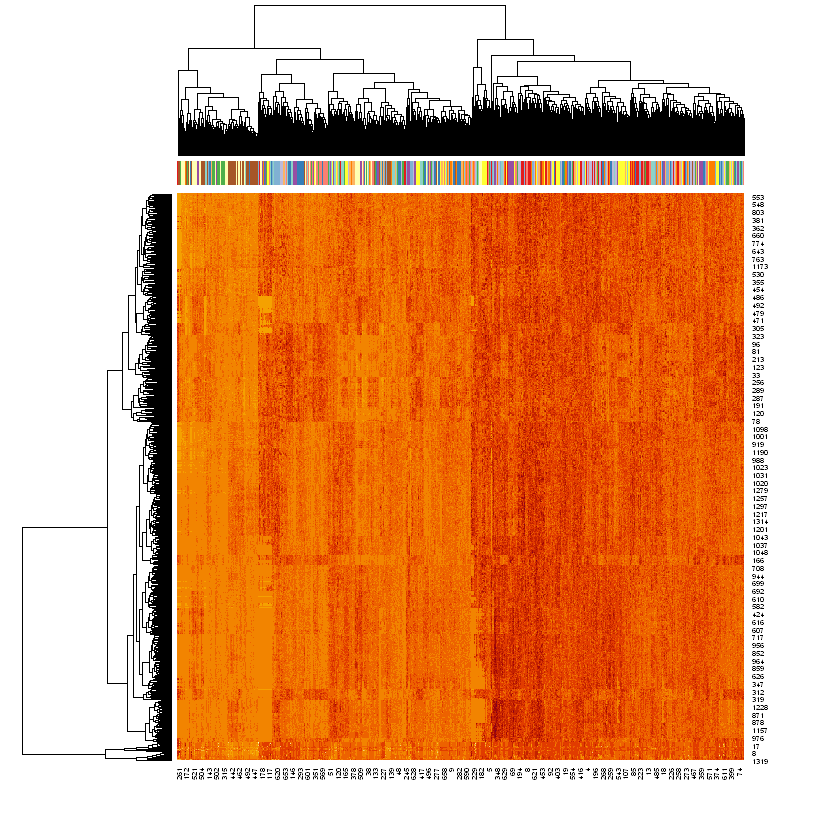

In [10]:
# View heatmap of Spectrograms
heatmap(rs.spectroAligned[rs.kruskal.stats<1E-20,],scale='r',
  ColSide=PALETTE[as.numeric(TRAINING.Y[flag])+1])



Call:
 randomForest(x = t(rs.spectroAligned[rs.kruskal.stats < 1e-10,      ]), y = factor(TRAINING.Y[flag]), ntree = 2500) 
               Type of random forest: classification
                     Number of trees: 2500
No. of variables tried at each split: 64

        OOB estimate of  error rate: 47.03%
Confusion matrix:
   00 01 02 03 04 05 06 07 08 09 10 11 12 class.error
00 27  4  2  0  3  3  1  2  0  8  1  2  1   0.5000000
01  2 32  0  0  0  4  2  0  6  8  5  0  2   0.4754098
02  5  3 19  2  0  1  2  3  7  0  4  3  0   0.6122449
03  2  6  2 24  0  6  1  0  4  4  0  5  0   0.5555556
04  3  4  1  1 16  4  0  2  1  0  0  4  5   0.6097561
05  2  4  0  1  0 39  2  1  0  6  3  4  1   0.3809524
06  2  2  1  2  1  1 43  1  2  0  0  2  1   0.2586207
07  3  2  0  0  0  0  8 24  2  1  6  2  0   0.5000000
08  0  2  1  2  1  3  7  1 30  1  2  0  0   0.4000000
09  0  7  0  0  0  6  0  0  0 39  5  2  1   0.3500000
10  5  2  1  1  0  5  0  0  2  5 24  0  0   0.4666667
11  4  4  2  1  0  3  1  1 

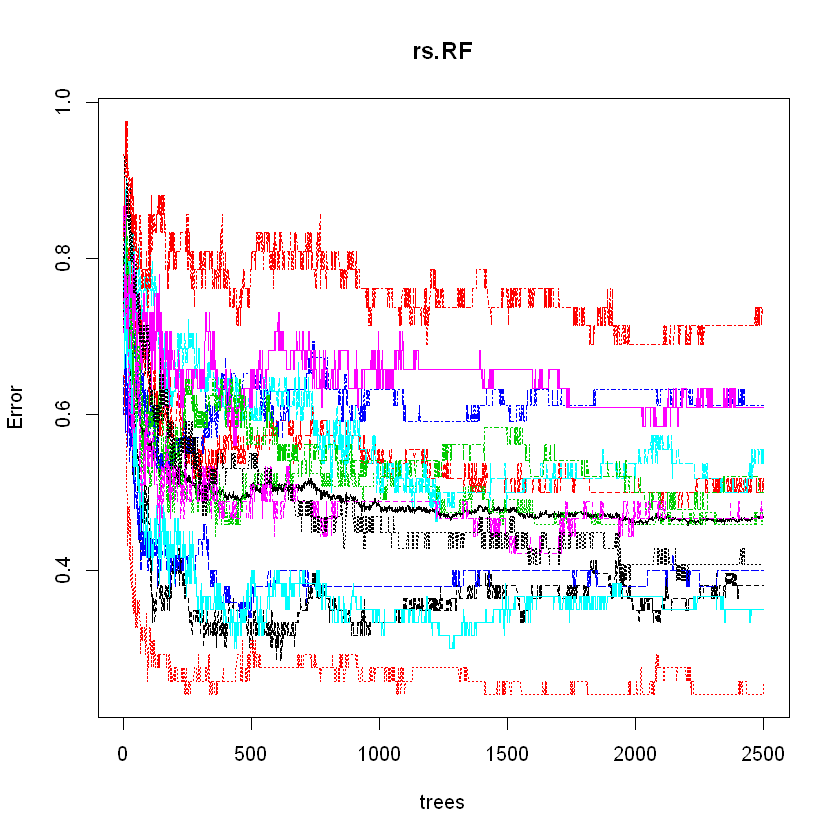

In [11]:
################ Random Forest

rs.RF = randomForest(t(rs.spectroAligned[rs.kruskal.stats<1E-10,]), factor(TRAINING.Y[flag]), ntree=2500)
plot(rs.RF)

rs.RF

In [12]:
saveRDS(rs.RF, file='random-forest-190702.rds')

In [13]:
################ Kernel regression

kerndata = matrix(0, length(TRAINING.X), sum(rs.kruskal.stats<1E-10))
kerndata[flag,] = t(rs.spectroAligned[rs.kruskal.stats<1E-10,])

# Get CV folds
set.seed(10)
cv.folds = randomlyPartition(which(flag), folds=10)
sapply(cv.folds,length)  # Number in each partition

# sample size in each fold
sapply(cv.folds, function(i)
  table(as.numeric(TRAINING.Y[setdiff(which(flag),i)]))
)


1  2  3  4  5  6  7  8  9 10 
64 63 71 66 72 61 64 66 65 82

,1,2,3,4,5,6,7,8,9,10
0,48,51,51,49,51,48,48,48,46,46
1,55,51,56,54,52,55,57,56,57,56
2,44,43,45,45,45,48,43,45,42,41
3,54,49,47,51,46,49,49,51,48,42
4,36,41,31,37,40,37,37,39,34,37
5,54,57,58,54,56,58,56,54,61,59
6,51,56,50,55,47,51,53,53,55,51
7,43,44,44,42,44,42,44,43,44,42
8,44,48,48,46,43,46,45,42,43,45
9,49,53,53,56,55,56,54,54,54,56


1 7.25e-05 
	 1 
	 2 
	 3 
	 4 
	 5 
	 6 
	 7 
	 8 
	 9 
	 10 
[[1]]
[1] 0.5192878

2 0.000145 
	 1 
	 2 
	 3 
	 4 
	 5 
	 6 
	 7 
	 8 
	 9 
	 10 
[[1]]
[1] 0.4451039

3 0.00029 
	 1 
	 2 
	 3 
	 4 
	 5 
	 6 
	 7 
	 8 
	 9 
	 10 
[[1]]
[1] 0.425816

4 0.0003625 
	 1 
	 2 
	 3 
	 4 
	 5 
	 6 
	 7 
	 8 
	 9 
	 10 
[[1]]
[1] 0.4362018

5 0.000725 
	 1 
	 2 
	 3 
	 4 
	 5 
	 6 
	 7 
	 8 
	 9 
	 10 
[[1]]
[1] 0.5118694



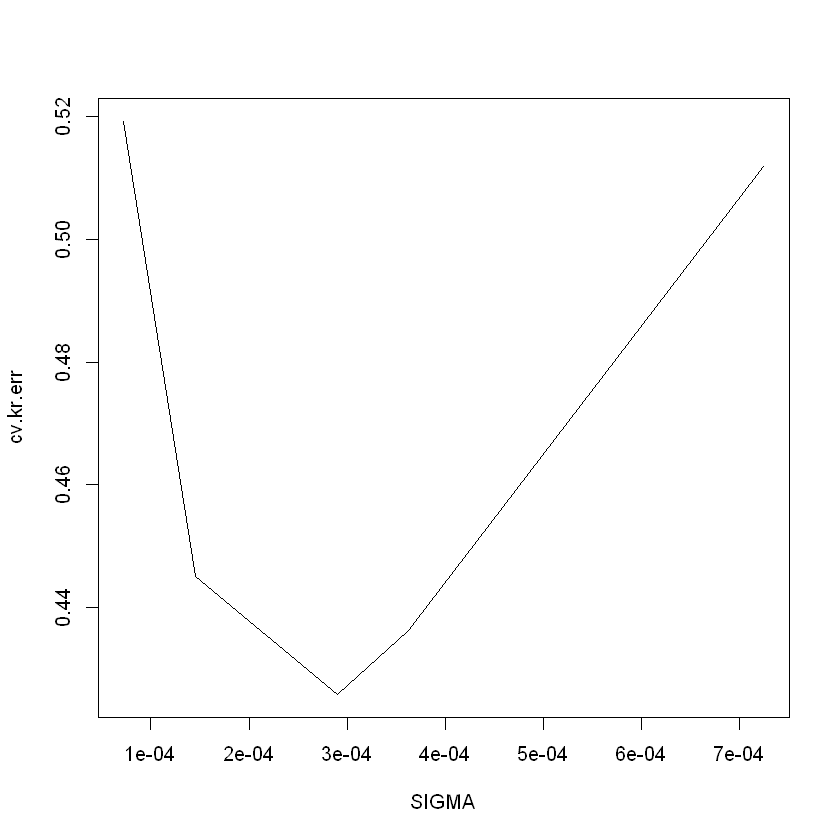

In [15]:
# Fit Gaussian kernel regressions for varying values of SIGMA
SIGMA = 0.000145 * c(0.5,1,2,2.5,5)
cv.kr.err = list()
cv.kr = list()
for(j in 1:length(SIGMA)){
  cat(j,SIGMA[j],'\n')
  cv.kr[[j]] = list()
  cv.pr = rep(NA, nrow(kerndata))
  for(k in 1:10){
    cat('\t',k,'\n')
    cvi = setdiff(which(flag),cv.folds[[k]])
    cv.kr[[j]][[k]] = ksvm(kerndata[cvi,],factor(TRAINING.Y[cvi]),C=1,kpar=list(sigma=SIGMA[j]))
    cv.pr[cv.folds[[k]]] = as.character(predict(cv.kr[[j]][[k]],newdata=kerndata[cv.folds[[k]],]))
  }
  cv.kr.err[j] = mean(cv.pr[flag]!=factor(TRAINING.Y[flag]))
  print(cv.kr.err[j])
}

plot(SIGMA, cv.kr.err, type='l')

In [17]:
#Get cross-tabulation for best KR model
best.kr = which.min(cv.kr.err)
rs.KR = cv.kr[[best.kr]]
cv.pr = rep(NA, nrow(kerndata))
for(k in 1:10){
    cvi = setdiff(which(flag),cv.folds[[k]])
    cv.pr[cv.folds[[k]]] = as.character(predict(rs.KR[[k]],newdata=kerndata[cv.folds[[k]],]))
}


In [21]:
rs.KRtab = table(cv.pr[flag], factor(TRAINING.Y[flag]))
print(rs.KRtab)

print(1-sum(diag(rs.KRtab))/sum(rs.KRtab)) #Error

    
     00 01 02 03 04 05 06 07 08 09 10 11 12
  00 35  2  6  2  2  2  2  3  0  0  7  2  2
  01  1 36  0  5  2  2  2  1  2  7  2  2  6
  02  3  1 23  0  2  1  2  3  1  0  1  1  3
  03  0  0  3 29  1  5  0  3  5  1  1  1  1
  04  0  0  0  0 17  1  1  0  0  0  0  1  4
  05  2  3  1  7  3 43  0  3  3  5  3  5  4
  06  1  3  0  0  1  0 40  4  5  0  0  0  2
  07  1  1  4  2  2  1  3 22  0  0  0  2  0
  08  0  3  6  2  0  0  4  0 30  0  2  0  0
  09  7 10  0  3  0  3  0  0  0 42  2  3  2
  10  0  0  2  0  0  1  0  7  2  2 26  0  0
  11  2  0  3  4  6  3  2  1  0  3  0 30  4
  12  2  2  1  0  5  1  2  1  2  0  1  2 14
[1] 0.425816


In [22]:
saveRDS(list(SIGMA=SIGMA, cv.kr.err=cv.kr.err, rs.KRtab=rs.KRtab), 
        file='kernel-regression-190702.rds')